# Solving the diffusion equation numerically
**Diffusion equation:**

\begin{alignat}{2}
{\partial u\over\partial t} &= D\Delta u + f \quad &&\hbox{ in }\Omega\times(0, T],
\label{eq:diffusion0:pde1}\\
u &= u_D &&\hbox{ on } \partial \Omega\times(0, T],
\label{eq:diffusion0:pde1:bc}\\
u &= u_0 &&\mbox{ at } t=0.
\label{eq:diffusion0:pde1:ic}
\end{alignat}

- Here, $u$ varies with space and time, e.g., $u=u(x,y,t)$ if the spatial
domain $\Omega$ is two-dimensional. 
- The source function $f$ and the boundary values $u_D$ may also vary with space and time.
- The initial condition $u_0$ is a function of space only.
- `D` is diffusivity or diffusion coefficient

**Solving equation in FEniCS** <br>
FEniCS is based on the finite element method, which is a general and efficient mathematical machinery for the numerical solution of PDEs (Partial differential equations)
Solving a boundary-value problem in FEniCS consists of the following steps:
1. Identify the computational domain $\Omega$, the PDE, its boundary conditions, and source terms $f$.
- Reformulate the PDE as a finite element variational problem.
- Write a Python program which defines the computational domain, the variational problem, the boundary conditions, and source terms, using the corresponding FEniCS abstractions.
- Call FEniCS to solve the boundary-value problem and, optionally, extend the program to compute derived quantities such as fluxes and averages, and visualize the results.

For the process of how to reformulate PDE and derive finite element variational problem please refer to the book [Solving PDEs in Python– The FEniCS Tutorial Volume I](https://fenicsproject.org/pub/tutorial/pdf/fenics-tutorial-vol1.pdf) by Hans Petter Langtangen and Anders Logg
<br><br>
**This notebook** will solve the diffusion in a simple rectangle domain with diffusivity is carbon diffusivity in steel and post-process some results that can help heat treater understand and improve carburising process.

# FEniCS implementation

In [1]:
from fenics import *
import numpy as np

## Mesh and Functionspace
- Computation domain is a rectangle which is defined by 2 poins `(0,0)` and `(xmax,ymax)`. Here we will define `xmax = ymax = 0.1`
- Meshing of domain:
    - Vertical edges will get discrete equally to `ny=100`
    - Horizontal edges will get discrete equally to `nx=5` <br>

**Notes:**<br>
- Units: Python doesn't have unit system, so we will have to define it consistently:
    - Length: mm
    - Time: s
    - Temperature: Celcius
    - Diffussion coefficient: $mm^2/s$
- Meshing: 
    - In carburising sometime it's a matter of $\mu m$ so in this example, we will have `mesh` that has smallest edge $$ymax/ny = 0.1/100mm = 0.001mm = 1\mu m$$
    - More complicated mesh can be done with FEniCS

In [2]:
# Create mesh and define function space
xmax=0.1
ymax=0.1
nx = 5
ny = 100
mesh = RectangleMesh(Point(0, 0), Point(xmax, ymax), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

## Initial condition
- All the nodes will have initial carbon content of `C_ini` = 0.002 (or 0.2%)
- Intuitively, `C_cal` stands for Carbon_content_calculated for every node, will be calculated in each time step, initially is `C_ini` entirely

In [3]:
# Initial condition
C_ini = Constant(0.002)
C_cal= interpolate(C_ini, V)

## Boundary condition
Reaction-diffusion might be complicated that involves distinct stages, e.g. carbon transport from the atmosphere to the steel surface, surface chemical reactions and absorption and then diffusion of the absorbed carbon. <br>
But here we make assumption: the top surface is constantly being supplied carbon, all the nodes will have 0.01 (1%) carbon, equal to the carbon potential of environment, all the time during carburising process

In [4]:
# Carbon potential of environment
C_env = Constant(0.01)

# Define boundary condition on top surface
y_top = 0.1
tol=1E-14
def on_top ( x, on_boundary ):
    return ( y_top - tol <= x[1] )
bc = DirichletBC(V, C_env, on_top)

# Apply boundary condition on FunctionSpace V
bc.apply(C_cal.vector())

## User input parameters
- `diff_time`: diffusion time [s]
- `num_steps`: number of time steps for calculation
- `D`: diffusion coefficient [$mm^2/s$]

In [5]:
diff_time= 10            # final time"
num_steps = 1000     # number of time steps
D =  Constant(2E-5) # Dummy number

## Solver
Again, for detail please refer to the book [Solving PDEs in Python– The FEniCS Tutorial Volume I](https://fenicsproject.org/pub/tutorial/pdf/fenics-tutorial-vol1.pdf) by Hans Petter Langtangen and Anders Logg

In [6]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

dt = diff_time / num_steps # time step size

F = u*v*dx + D*dt*dot(grad(u), grad(v))*dx - (C_cal + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for k in range(num_steps):    
    t += dt             # Update current time    
    solve(a == L, u,bc) # Compute solution    
    C_cal.assign(u)     # Update previous solution

# Post-processing
Now we have solved the diffusion problem and results are stored somewhere in `C_cal`

## Getting carbon content at certain depths
Let's say we are interested in looking at carbon profile, or how carbon concentration varies from surface to the core...

In [7]:
j=0
C = np.zeros(ny+1,dtype=float)
for i in range(len(mesh.coordinates())):    
    if mesh.coordinates()[i][0]==0:
        C[j]=C_cal.compute_vertex_values()[i]
        j+=1

## Plotting
`depths` is an array that store distances of nodes to surface and we know it is [0,1,2,...down to 100] $\mu m$ <br>
`C` is an array that has same shape as `depths`, store carbon content of nodes (reversely corresponds to value of `depths` in this case)

In [8]:
C = C[::-1]
depths = np.arange(0,101)

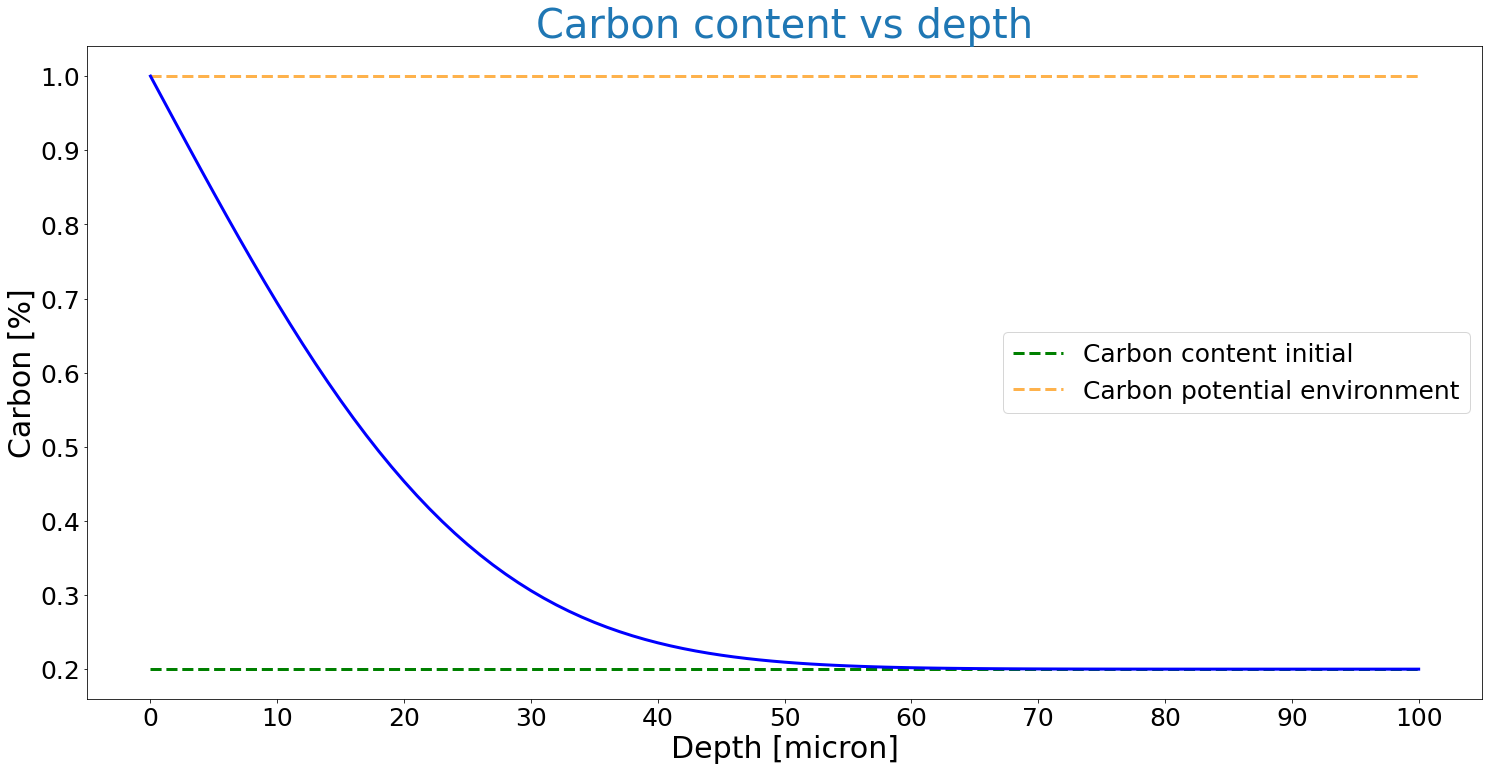

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

plt.plot(depths,C*100,color='b', linewidth=3)

ax=plt.gca()

# Horizontal line
plt.hlines(0.2,-0,100,linewidth=3, color='g', linestyles='dashed', label='Carbon content initial')
plt.hlines(1.0,-0,100,linewidth=3, color='#feb24c', linestyles='dashed', label='Carbon potential environment')


# Ticks
major_xticks = np.arange(0, 101,10)
major_yticks = np.arange(0.2, 1.1, 0.1)
ax.set_xticks(major_xticks)
ax.set_yticks(major_yticks)

# Decimal places on ticks
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # 0 decimal places
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places

# Ticks size
ax.tick_params(axis='x', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', labelsize=25)

# Graph title
title = 'Carbon content vs depth'
plt.title(title, c= 'tab:blue', fontsize=40)

# Axes label
xlabel = 'Depth [micron]'
ylabel = 'Carbon [%]'
plt.xlabel(xlabel,fontsize=30)
plt.ylabel(ylabel,fontsize=30)

# Legends position
plt.legend(loc='center right', fontsize=25)

# Figure size
fig_size = (25, 12)
plt.gcf().set_size_inches(fig_size)

plt.show()

# References

- [Solving PDEs in Python – The FEniCS Tutorial Volume I, by Hans Petter Langtangen and Anders Logg](https://fenicsproject.org/pub/tutorial/pdf/fenics-tutorial-vol1.pdf) 
<br><br>
- [CarbTool – Leading the Way in Case-Depth Simulations](https://www.industrialheating.com/articles/93091-carbtool---leading-the-way-in-case-depth-simulations)